# Initial Data Exploration and Visualization

## Group number: 13

### Team members: Soheil: sf3116, Allan C: ac5439, Fernando: fc2672, Jahnavi M: jm5667, Kevin Y: zy2582

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor  
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import brier_score_loss
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read data
amex_train = pd.read_csv('train_data.csv', index_col = 'customer_ID')

In [4]:
# read labels
amex_train_labels = pd.read_csv('train_labels.csv', index_col = 'customer_ID')

In [5]:
# merge data with labels based on Customer ID
train_with_labels = amex_train.merge(amex_train_labels, on='customer_ID', how='left')

In [40]:
# target distribution
target_dist = amex_train_labels.groupby(by=['target']).size() / amex_train_labels.size

### Initial Data Explorations

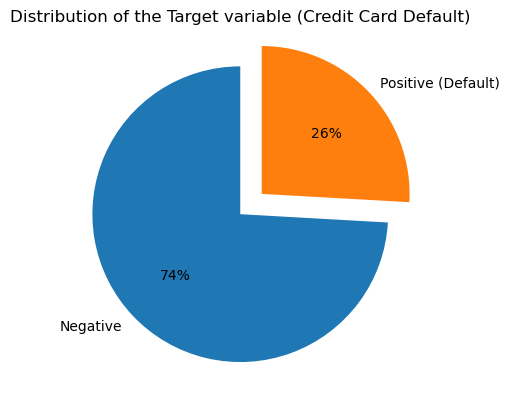

In [53]:
# Pie chart for the distribution of the target
pie_labels = ["Negative", "Positive (Default)"]
pie_myexplode = [0, 0.2]
plt.pie(target_dist, labels = pie_labels, explode = pie_myexplode, startangle = 90, autopct='%1.f%%')
plt.title("Distribution of the Target variable (Credit Card Default)")
plt.show() 

In [63]:
# Count the features by category
Delinquency = sum(column.startswith('D') for column in amex_train.columns)
Spend = sum(column.startswith('S') for column in amex_train.columns)
Payment = sum(column.startswith('P') for column in amex_train.columns)
Balance = sum(column.startswith('B') for column in amex_train.columns)
Risk = sum(column.startswith('R') for column in amex_train.columns)

data = {
    'Delinquency': [sum(column.startswith('D') for column in amex_train.columns)],
    'Balance' : [sum(column.startswith('B') for column in amex_train.columns)],
    'Risk' : [sum(column.startswith('R') for column in amex_train.columns)],
    'Spend' : [sum(column.startswith('S') for column in amex_train.columns)],
    'Payment' : [sum(column.startswith('P') for column in amex_train.columns)]
}

df = pd.DataFrame(data)
df

,Delinquency,Balance,Risk,Spend,Payment
0,96,40,28,22,3


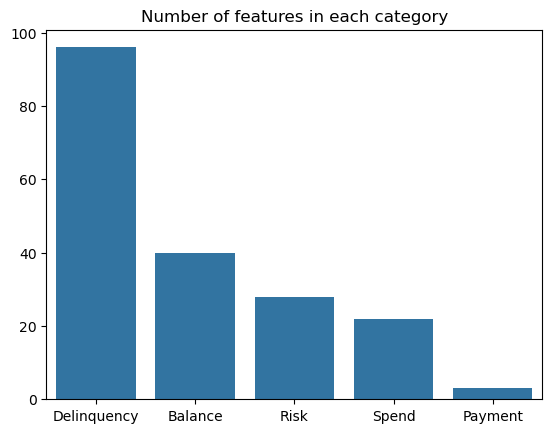

In [83]:
# plot categories
sns.barplot(data=df, color='#1f77b4')
plt.title("Number of features in each category")
plt.show()

In [6]:
# numeric training data 
train_with_labels_num = train_with_labels.drop(columns= ['S_2' ,'B_30', 'B_38', 'D_114', \
                                                         'D_116', 'D_117', 'D_120', 'D_126', \
                                                         'D_63', 'D_64', 'D_66', 'D_68'])

In [7]:
# reset index
train_with_labels_num.reset_index(inplace=True)
train_with_labels.reset_index(inplace=True)

In [152]:
# number of rows per customer
rows_per_cust = grouped_cust.groupby(by=grouped_cust[1:]).size()
df_rows_per_cust =pd.DataFrame(rows_per_cust)
df_rows_per_cust.reset_index(inplace=True)

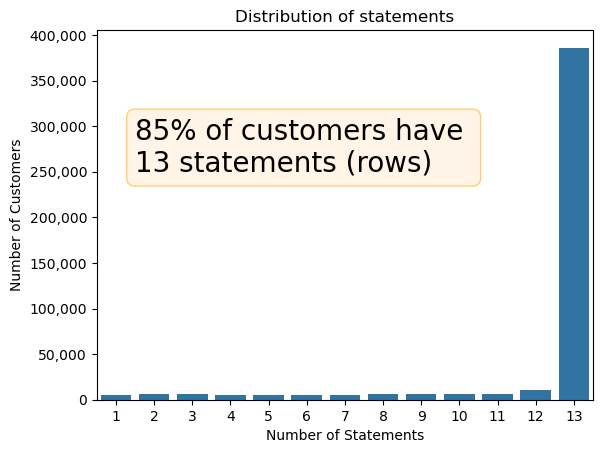

In [175]:
# plot number of rows (statements) per customer
sns.barplot(data=df_rows_per_cust, x= df_rows_per_cust.iloc[:, 0].astype(int)\
            , y=df_rows_per_cust.iloc[:, 1], color='#1f77b4')
plt.title("Distribution of statements")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel("Number of Statements")
plt.ylabel("Number of Customers")
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
plt.text(0.5, 250000, "85% of customers have \n13 statements (rows)", fontsize= 20, bbox=bbox)
plt.show()

### Missing data distribution

In [232]:
# missing values
missing_vals = (amex_train.isnull().sum())/5531451

In [233]:
percent_missin_values=pd.DataFrame(missing_vals)

In [234]:
percent_missin_values.columns = ['percentage_missing']

In [235]:
# number of features with missing values
sum(percent_missin_values['percentage_missing']>0)

122

In [250]:
percent_missin_values_top=percent_missin_values[percent_missin_values['percentage_missing']>0.3]

In [242]:
# sort features with highest missing values
percent_missin_values.sort_values(by='percentage_missing', ascending = False)

,percentage_missing
D_87,0.999301
D_88,0.998915
D_108,0.994768
D_110,0.994335
D_111,0.994335
...,...
D_75,0.000000
P_4,0.000000
B_23,0.000000
S_15,0.000000


<Figure size 1000x2000 with 0 Axes>

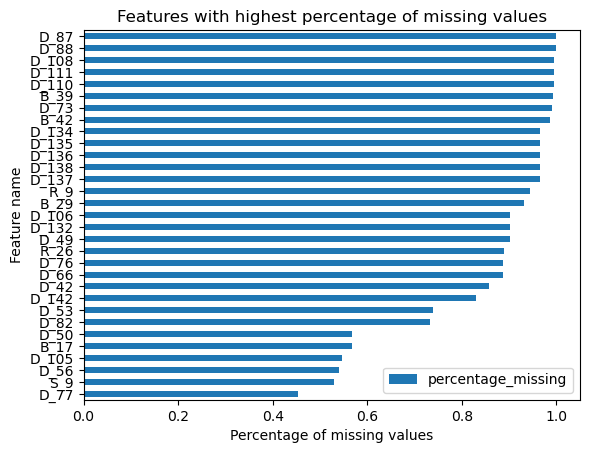

In [267]:
# plot features with highest percent of missing values
plt.figure(figsize=(10,20))
percent_missin_values_top.sort_values(by='percentage_missing').plot.barh()
plt.title("Features with highest percentage of missing values")
plt.xlabel("Percentage of missing values")
plt.ylabel("Feature name")
plt.show()

In [218]:
# missing values statistics
percent_missin_values.describe()

,percentage_missing
count,189.000000
mean,0.153867
std,0.319821
min,0.000000
25%,0.000000
50%,0.001252
75%,0.031947
max,0.999301


### Data Aggregation
since we have multiple rows per customer, we need to aggregate rows per customer

In [10]:
features = train_with_labels.drop(['customer_ID', 'S_2', 'target'], axis=1).columns.to_list()
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
num_features = [col for col in features if col not in cat_features]

In [11]:
train_num_agg = train_with_labels.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
train_cat_agg = train_with_labels.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
train_target = (train_with_labels.groupby("customer_ID").tail(1).set_index('customer_ID', drop=True).sort_index()["target"])
train = pd.concat([train_num_agg, train_cat_agg, train_target], axis=1)

In [12]:
# shape of the new transformed data
train.shape

(458913, 919)

### Visiualizing Categorical Features

Text(0, 0.5, 'Count')

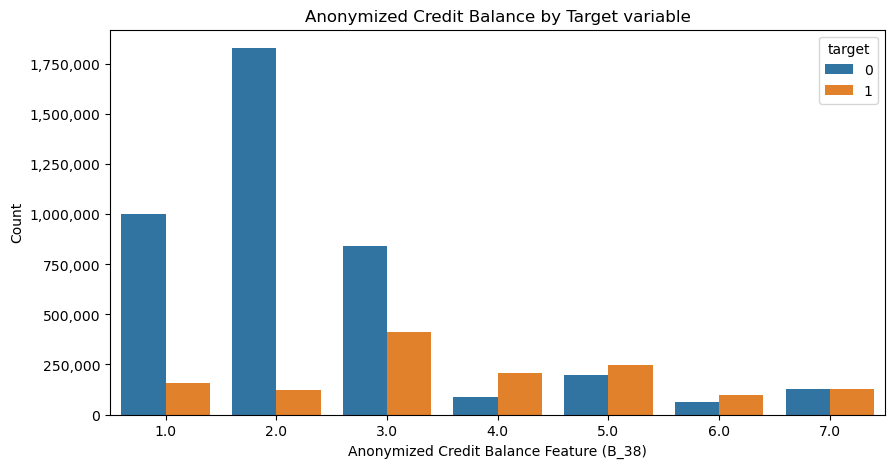

In [295]:
plt.figure(figsize = (10,5))
plot1 = sns.countplot(data = train_with_labels, x ='B_38', hue = 'target')
plt.title("Anonymized Credit Balance by Target variable")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel("Anonymized Credit Balance Feature (B_38)")
plt.ylabel("Count")


Text(0, 0.5, 'Count')

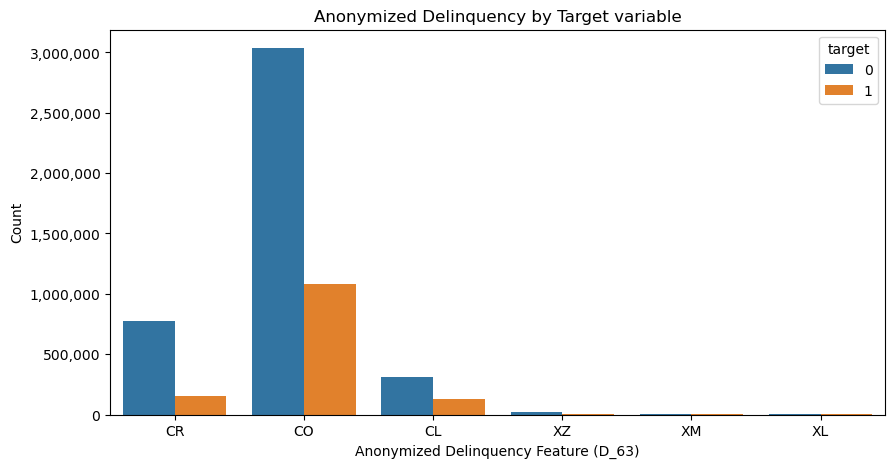

In [299]:
plt.figure(figsize = (10,5))
plot1 = sns.countplot(data = train_with_labels, x ='D_63', hue = 'target')
plt.title("Anonymized Delinquency by Target variable")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel("Anonymized Delinquency Feature (D_63)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

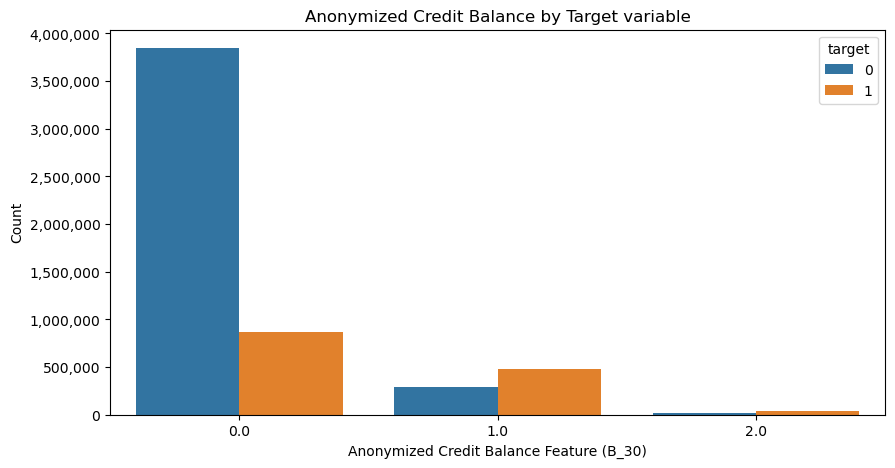

In [302]:
plt.figure(figsize = (10,5))
plot1 = sns.countplot(data = train_with_labels, x ='B_30', hue = 'target')
plt.title("Anonymized Credit Balance by Target variable")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel("Anonymized Credit Balance Feature (B_30)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

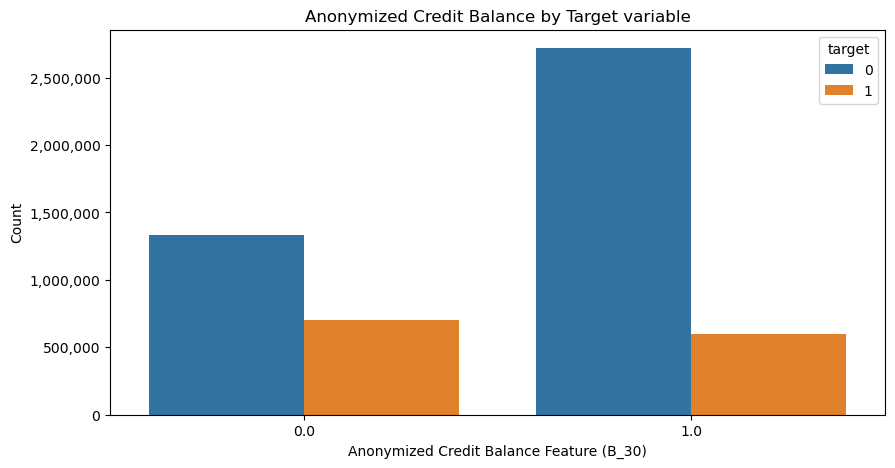

In [304]:
plt.figure(figsize = (10,5))
plot1 = sns.countplot(data = train_with_labels, x ='D_114', hue = 'target')
plt.title("Anonymized Credit Balance by Target variable")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel("Anonymized Credit Balance Feature (B_30)")
plt.ylabel("Count")

### Visualizing Correlations

In [ ]:
cor_matrix = train_with_labels_num.corr()
plt.figure(figsize = (20,25)) 
sns.heatmap(cor_matrix, cmap="crest") 
plt.show()

In [320]:
correlation_matrix = cor_matrix

In [345]:
threshold = 0.5
# Iterate through the correlation matrix to find highly correlated pairs
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(pair)
# print("Highly correlated pairs:")
# for pair in highly_correlated_pairs:
#     print(pair)

In [335]:
top_correlated_vars = ['P_2', 'B_2', 'D_44', 'D_48', 'B_7', 'B_9', 'D_55', 'D_58', 'B_18', 'D_74', 'D_75', 'B_33', 'B_1', 'B_3', 'B_11', 'B_16', 'B_19', 'B_20', 'B_22', 'target']

In [336]:
train_with_labels_top_20_corr = train_with_labels_num[top_correlated_vars]
cor_matrix = train_with_labels_top_20_corr.corr()

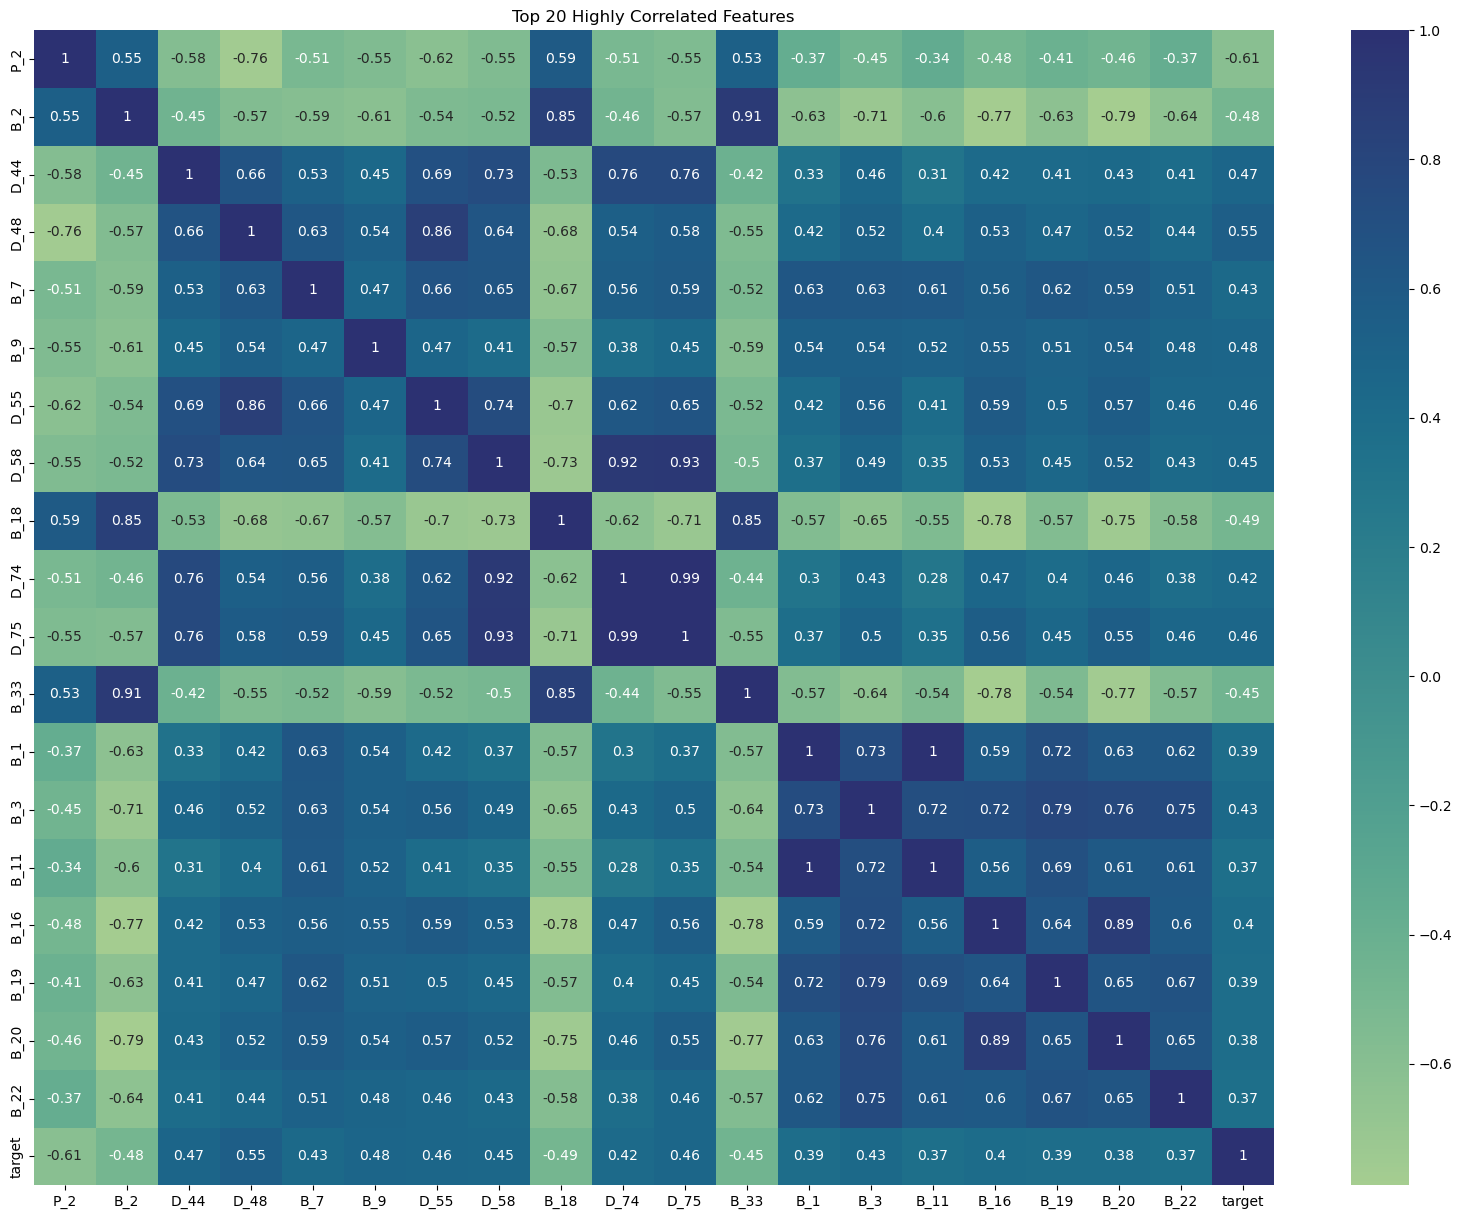

In [344]:
plt.figure(figsize = (20,15)) 
plt.title("Top 20 Highly Correlated Features")
sns.heatmap(cor_matrix, annot=True, cmap="crest") 
plt.show()

### Visualizing numerical features

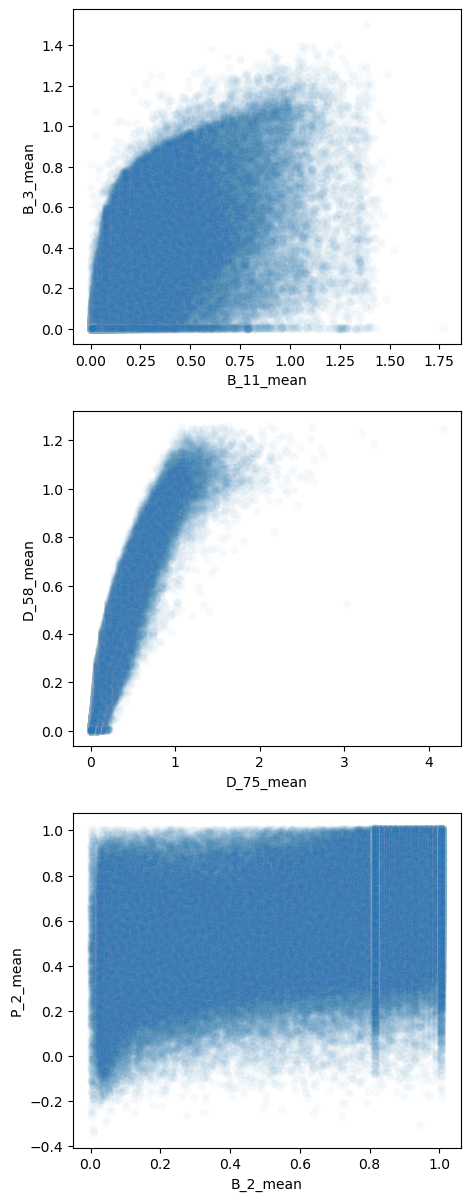

In [371]:
plt.figure(figsize = (5,20))
plt.subplot(4,1,1)
sns.scatterplot(data = train, x = "B_11_mean", y = "B_3_mean", alpha =0.03)
plt.subplot(4,1,2)
sns.scatterplot(data = train, x = "D_75_mean", y = "D_58_mean", alpha =0.03)
plt.subplot(4,1,3)
sns.scatterplot(data = train, x = "B_2_mean", y = "P_2_mean", alpha =0.03)
plt.show()